---
## Note from the Teachers:
We added a header with information about your project. 
This is useful since we want to keep a database of all the cool projects participants have made during the courses.
We will save the code in our database and host on github a page to show all the projects. Therefore it is more practical to add some information in the header of each notebook.
Thanks a lot for the understanding and for taking care of it.

You can delete this cell if you want

---

# Project Name: Backery sales prediction
We want to predict the sales of different products from a bakery. For example we show the results for one of the sold products.

## Participants:
Please list here all the participants alongside with any information you may want to be visible. This will be hosted on a opencampus.sh repository, so if you want to keep a connection to your github user include this information here.
\
Christopher Hansen, Niko Schmidt, Amelie Schmücker, Samira Ferssioui

### Course and Semester
Summer semester 2021; Deep Learning from Scratch

### License

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
\
Further there is absolute no warranty for the provided code.

##Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import holidays
import csv
import os
import pandas as pd

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot

from tensorflow import keras
from tensorflow.keras.layers import LSTM
from tensorflow.keras import layers

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import concatenate



In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [3]:
mae = tf.keras.losses.MeanAbsoluteError()

In [4]:
#In case of Google Colab run this:
from google.colab import files
uploaded = files.upload()


Saving kiwo.csv to kiwo.csv
Saving sales.csv to sales.csv
Saving wheather.csv to wheather.csv


In [5]:
import io
sales_df = pd.read_csv(io.BytesIO(uploaded['sales.csv']))
weather_df =  pd.read_csv(io.BytesIO(uploaded['wheather.csv']))
kiwo_df =  pd.read_csv(io.BytesIO(uploaded['kiwo.csv']))

In [6]:
#In case of local github export run this:
#DATA_FOLDER = './../data'
#SALES_DATA = 'sales.csv'
#WEATHER_DATA = 'wheather.csv'

#sales_df = pd.read_csv(os.path.join(DATA_FOLDER, SALES_DATA))
#weather_df = pd.read_csv(os.path.join(DATA_FOLDER, WEATHER_DATA))

In [7]:
kiwo_df

,Date,KielerWoche
0,2012-06-16,1
1,2012-06-17,1
2,2012-06-18,1
3,2012-06-19,1
4,2012-06-20,1
...,...,...
67,2019-06-26,1
68,2019-06-27,1
69,2019-06-28,1
70,2019-06-29,1


In [8]:
sales_df

,Date,Group,Sales
0,2013-07-01,1,148.828353
1,2013-07-02,1,159.793757
2,2013-07-03,1,111.885594
3,2013-07-04,1,168.864941
4,2013-07-05,1,171.280754
...,...,...,...
10864,2018-12-22,6,66.737353
10865,2018-12-23,6,49.958196
10866,2018-12-24,6,46.130749
10867,2018-12-27,6,51.623140


In [9]:
weather_df

,Date,Cloudiness,Temperature,Wind Speed,Weather Code
0,2012-01-01,8.0,9.8250,14,58.0
1,2012-01-02,7.0,7.4375,12,NaN
2,2012-01-03,8.0,5.5375,18,63.0
3,2012-01-04,4.0,5.6875,19,80.0
4,2012-01-05,6.0,5.3000,23,80.0
...,...,...,...,...,...
2596,2019-07-28,3.0,23.3500,14,5.0
2597,2019-07-29,6.0,25.2500,7,61.0
2598,2019-07-30,7.0,20.7375,8,61.0
2599,2019-07-31,6.0,20.4500,7,61.0


## Functions


### separateGroups

Returns 6 dataframes with the different groups separated.


sales_df:  
*Expects the dataframe containing the 6 sales groups.*

returns: sales_df_group1, sales_df_group2, sales_df_group3, sales_df_group4, sales_df_group5, sales_df_group6

In [10]:
def separateGroups(sales_df):
    is_group1 = sales_df['Group'] == 1
    is_group2 = sales_df['Group'] == 2
    is_group3 = sales_df['Group'] == 3
    is_group4 = sales_df['Group'] == 4
    is_group5 = sales_df['Group'] == 5
    is_group6 = sales_df['Group'] == 6
    
    sales_df_group1 = sales_df[is_group1]
    sales_df_group2 = sales_df[is_group2]
    sales_df_group3 = sales_df[is_group3]
    sales_df_group4 = sales_df[is_group4]
    sales_df_group5 = sales_df[is_group5]
    sales_df_group6 = sales_df[is_group6]
    
    return sales_df_group1, sales_df_group2, sales_df_group3, sales_df_group4, sales_df_group5, sales_df_group6

### matchWatherAndSales

Returns one dataframe that contains weather and sales data.

sales_df:  
*Expects the dataframe containing the 6 sales groups.*  
weather_df:  
*Expects the dataframe containing the weather data.*  

In [11]:
def matchWeatherAndSales(sales_df, weather_df):
    sales_df_prepared = sales_df[sales_df['Date'].isin(weather_df['Date'])]
    weather_df_prepared = weather_df[weather_df['Date'].isin(sales_df['Date'])]
    
    weather_df_prepared = weather_df_prepared.drop(columns=['Date'])
    
    sales_df_prepared = sales_df_prepared.reset_index(drop=True)
    weather_df_prepared = weather_df_prepared.reset_index(drop=True)
    
    sales_and_weather_combined = sales_df_prepared.join(weather_df_prepared)
    
    sales_and_weather_combined = sales_and_weather_combined.dropna()
    sales_and_weather_combined = sales_and_weather_combined.reset_index(drop=True)
    
    return sales_and_weather_combined

### MatchWeekDays

Parameter x expects a dataframe containing dates.

Returns a list y containing the weekdays to your dataframe.




In [12]:
def MatchWeekDays(x):
  # We call the function in MatchWeatherAndSales
  # We make a list of the weekdays
  y = []
  # We first transform from the isoformat which is for example 2012-01-01
  for k in range(0,len(x.iloc[:,0])):
    y.append(datetime.datetime.fromisoformat(x.iloc[k,0]))
  # Next we transfer to day of week.
  for k in range(0,len(x.iloc[:,0])):
    y[k] = datetime.date.isoweekday(y[k])
  return y

### MarkPublicHolidays

Returns is_holiday, a dataframe that contains if a date is a holiday in Schleswig-Holstein or not.

weather_df:  
*Expects a dataframe containing dates*  


In [103]:
import holidays
# get holiday list for Germany SH
ger_sh_holidays = holidays.CountryHoliday('DE',prov='SH')
# we make the function
def MarkPublicHolidays(weather_df):
  # Again we make a list
  is_holiday = []
  for k in range(len(weather_df.iloc[:,0])):
    is_holiday.append(weather_df.iloc[k,0] in ger_sh_holidays)
  for k in range(len(weather_df.iloc[:,0])):
    if(is_holiday[k] == True):
      is_holiday[k] = 1
    if(is_holiday[k] == False):
      is_holiday[k] = 0
  return is_holiday

### removeKiwoFromDataset

Returns sales_and_weather_combined_no_kiwo, one dataframe that does not include the data for the Kieler Woche.

sales_and_weather_combined:  
*Expects the dataframe with sales and weather data*  
kiwo_df:  
*Expects a dataframe with the KiWo dates*
  

In [14]:
def removeKiwoFromDataset(sales_and_weather_combined, kiwo_df):
  sales_and_weather_combined_no_kiwo = sales_and_weather_combined[~sales_and_weather_combined['Date'].isin(kiwo_df['Date'])]

  return sales_and_weather_combined_no_kiwo

### series_to_supervised

To use the provided data in an LSTM network we need to convert the time series data to a supervised type. This is done by shifting the values from t to t-i and putting them together in one dataframe, so one row contains the label y as well as x1_t, x1_t-i, x2_t, x2_t-i....

Retuns agg, the above described combined dataframe

data:  
*Expects a dataframe with the data to convert*  
n_in:  
*Expects the minus shift from the input as integer*  
n_out:  
*Expects the plus shift from the output as integer*  

In [15]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
	# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

### prepareForSeriesToSupervised
prepares the dataframe for the LSTM Model where unnecessary columns are dropped, scales X to be between 0 and 1

Returns the dataframe dataset_scaled.

df:  
*Expects the dataframe with weather and sales data*




  

In [16]:
def prepareForSeriesToSupervised(df):
  df = df.drop(columns=['Date', 'Group', 'Cloudiness', 'Temperature', 'Wind Speed', 'Weather Code'])
  dataset = df.values
  X = dataset[:,1:3]
  Y = dataset[:,0]
  min_max_scaler = preprocessing.MinMaxScaler()

  X_scaled = min_max_scaler.fit_transform(X)
  X_scaled_df = pd.DataFrame(X_scaled)
  Y_df = pd.DataFrame(Y)
  X_scaled_df.insert(0,0,Y_df, True)
  dataset_scaled = X_scaled_df.values


  return dataset_scaled

### compileModelAdamMseAcc
Compiles the Model using the Adam Optimizer and applies a learning rate scheduler.

Returns buildModel which is the model after compilation.

buildModel:  
*Expects a model before compilation as input*


In [17]:
def compileModelAdamMseAcc(buildModel):
  #Compile the model
  #Input: model from buildModel
  #Return: buildModel after compilation
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  buildModel.compile(optimizer = optimizer,
                loss='mae', metrics=['mae'])
  
  return buildModel

### buildModelDNN
Builds the DNN Model. It is made of 7 layers plus 1 output layer. As an activation function 'ReLu' activation has been used. To reduce overfitting dropout layers have been implemented. The L2 regularizer has not been used as the parameter is set to 0.0


Returns model, which is the DNN model

In [18]:
def buildModelDNN():
  # build the network
  model = Sequential()
  #print("Input dimensions: ",x_train.shape[1:])
  d_rate = 0.9
  reg = 0.0
  model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(reg), input_shape=(5,))) #5 Inputs: Cloudiness, Temperature, Wind Speed, Day of week, month
  Dropout(d_rate)
  model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  Dropout(d_rate)
  model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  #Dropout(d_rate)
  model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  #Dropout(d_rate)
  model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(reg)))
  #Dropout(d_rate)
  model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  model.add(Dense(16,activation='relu'))
  model.add(Dense(1, activation='relu'))
  
  print(model.summary())
  return model

### fitModel
Fits the model to the Training and Validation Set

Returns history, the history of the model.

xTrain, yTrain, xVal, yVal:  
*Expects the train and validation data for the model as np.array*  
trainingEpochs:  
*Number of epochs as integer*  
compiledModel:  
*The compiled model that should be fit*


In [19]:
def fitModel(xTrain, yTrain, xVal, yVal, trainingEpochs, compiledModel):
  #Fit the model
  #Input: compiled Model, Train and Validation Data, Batch Size and trainingEpochs
  #Return: history and model
  history = compiledModel.fit(xTrain, yTrain,batch_size=128, epochs = trainingEpochs, validation_data=(xVal, yVal))

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

  return history

### fitModelLearningRateTuner

This function is used to determine a good starting learning rate. After using this function plot the history["lr"] and history["loss"] on a semilog scale. Where the function has its minimum use this as a starting learning rate for your model.

Returns history, the history of the model.

xTrain, yTrain, xVal, yVal:  
*Expects the train and validation data for the model as np.array*  
trainingEpochs:  
*Number of epochs as integer*  
compiledModel:  
*The compiled model that should be fit*


In [20]:
def fitModelLearningRateTuner(xTrain, yTrain, xVal, yVal, trainingEpochs, compiledModel):
  #Fit the model
  #Input: compiled Model, Train and Validation Data, Batch Size and trainingEpochs
  #Return: history and model
  optimizer = tf.keras.optimizers.Adam(lr=1e-6)
  compiledModel.compile(optimizer = optimizer,
                loss='mae', metrics=['mae'])
  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

  history = compiledModel.fit(xTrain, yTrain,batch_size=512, epochs = trainingEpochs,callbacks=[lr_schedule])
  return history

### xAndYSplit

drops unnecessary columns, splits dataset into X and Y, scales X between 0 and 1 

Returns X_scale and Y  

df:  
*Expects a dataframe to split*


In [21]:
def xAndYSplit(df):
  df = df.drop(columns=['Date', 'Group','Weather Code','isHoliday'])
  dataset = df.values
  X = dataset[:,1:9]
  Y = dataset[:,0]
  Y = Y
  min_max_scaler = preprocessing.MinMaxScaler()
  X_scale = min_max_scaler.fit_transform(X)
  

  return X_scale, Y

### trainDevTestSplit
Splits the dataset into train and dev set, then the dev set into dev and test 50/50

Returns xTrain, yTrain, xDev, yDev, xTest, yTest  

X:  
*Expects the X values*  
Y:  
*Expects the labels*  
testSize:  
*Expects a float how much percent should be validation set*  
randomSeed:  
*Random integer seed to ensure reproducability*


In [22]:
def trainDevTestSplit(X, Y, testSize, randomSeed):
  #Splits by test size into Train / Dev
  #Splits dev then 50/50 into dev and Test

  xTrain, xDev, yTrain, yDev = train_test_split(X, Y, test_size=testSize, random_state=randomSeed)

  xTest = xDev[:len(xDev)//2]
  yTest = yDev[:len(yDev)//2]
  
  xDev = xDev[len(xDev)//2:]
  yDev = yDev[len(yDev)//2:]

  return xTrain, yTrain, xDev, yDev, xTest, yTest

### makeLSTM
builds LSTM model on train and test set

history, model
*returns fitted model and model* 

Builds the LSTM  Model. It is made of 8 LSTM layers plus 1 dense output layer. As an activation function 'ReLu' activation has been used. To reduce overfitting dropout layers have been implemented. The L2 regularizer has not been used as the parameter is set to 0.0

Returns model, which is the LSTM model

In [23]:
def makeLstm(train_X, train_y, test_X, test_y):
  # design network
  model = Sequential()
  d_rate = 0.9
  reg = 0.0
  model.add((LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]))))
  Dropout(d_rate)
  model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(reg), input_shape=(5,))) #5 Inputs: Cloudiness, Temperature, Wind Speed, Day of week, month
  Dropout(d_rate)
  model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  Dropout(d_rate)
  model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  Dropout(d_rate)
  model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  Dropout(d_rate)
  model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(reg)))
  Dropout(d_rate)
  model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(reg)))
  model.add(Dense(16,activation='relu'))
  Dropout(0.2)
  model.add(Dense(1))

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.91)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  model.compile(loss='mae', optimizer=optimizer)
  # fit network
  history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
  # plot history
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

  return history, model

###TestPrediction
predicts values for the test set

Returns predictions for the test set  

xTest:  
*Test input values without y labels*


In [24]:
def TestPrediction (xTest):

  predictions = model.predict(xTest)
  print("predictions shape:", predictions.shape)

  return predictions

###PlotPrediction
Plots the Test Set Predictions by Sales per Day


In [25]:
def PlotPrediction (yTest):
  plt.plot(predictions)
  plt.plot(yTest)
  plt.title('Test Set Predictions')
  plt.ylabel('Sales')
  plt.xlabel('Day')
  #plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  return 

###Fourier Analysis

Explanation below where the Fourier Analysis is executed.

In [26]:
def FourierAnalysis(SalesKnown,d,ToPredict):
	# x is the array to approx
  # y is the area to predict
	# d is the number of coefficients, that should be used
	# we get the length of the array
	k = np.size(SalesKnown)
	
	# calculate the fourier transform with a library
	fourier = np.fft.fft(SalesKnown)
	indices = np.argsort(fourier.real*fourier.real+fourier.imag*fourier.imag)

	helpz = np.zeros((len(ToPredict),1),dtype=np.complex_)
	for m in range(0,np.size(ToPredict)):
		for l in range(0,d):
			helpz[m,0] = helpz[m,0] + 1.0/k * fourier[indices[k-1-l]]*np.exp(1j*2*np.pi*(m+l)*indices[k-1-l]*7.0*1.0/k)
	return helpz

In [27]:
def MovingAverage(Sales):
  # we input the sales and use k-9 until k to predict k
  Guessed = np.zeros((len(Sales)-10,1))
  for k in range(10,len(Sales)):
    for j in range(k-10,k):
      Guessed[k-10,0] = Guessed[k-10,0] + Sales.iloc[j,2]
  Guessed = Guessed/10.0
  return Guessed

In [28]:
def optimal_number_fouriercoefficients(yTrain,yDev):
  helpz = np.zeros((len(yDev),1))
  res_old=mae(helpz,yDev)
  min = len(yTrain)
  if(200<min):
    min = 200
    # We do not want to do to much iterations.
  for k in range(1,200):
    helpz = FourierAnalysis(yTrain,k,helpz)
    res_new = mae(helpz,yDev)
    if(res_new<res_old):
      numbers = k
      res_old = res_new


  # returns the optimal number of fourier coefficients for the dev set.
  return k

In [29]:
def Plotting(y_pred,y_real):
  # compares y_pred and y_real
  plt.plot(y_pred)
  # help vector to get the same position
  help = np.arange(len(y_real))
  plt.plot(help,y_real)
  plt.xlabel("Day")
  plt.ylabel("Sales")
  plt.legend(['Predictions', 'Real sales'], loc='upper right')
  plt.show()

  return 

## Data Preparation

In [30]:
sales_df_group1, sales_df_group2, sales_df_group3, sales_df_group4, sales_df_group5, sales_df_group6 = separateGroups(sales_df)

In [31]:
sales_df_group1

,Date,Group,Sales
0,2013-07-01,1,148.828353
1,2013-07-02,1,159.793757
2,2013-07-03,1,111.885594
3,2013-07-04,1,168.864941
4,2013-07-05,1,171.280754
...,...,...,...
2110,2019-05-27,1,135.089885
2111,2019-05-28,1,154.363980
2112,2019-05-29,1,190.850121
2113,2019-05-30,1,85.145930


Add Weekdays and Month to the dataframe

In [32]:
week_days = MatchWeekDays(weather_df)
weather_df = weather_df.assign(DayOfWeek=week_days)
weather_df['month'] = pd.DatetimeIndex(weather_df['Date']).month
print(weather_df)

            Date  Cloudiness  Temperature  ...  Weather Code  DayOfWeek  month
0     2012-01-01         8.0       9.8250  ...          58.0          7      1
1     2012-01-02         7.0       7.4375  ...           NaN          1      1
2     2012-01-03         8.0       5.5375  ...          63.0          2      1
3     2012-01-04         4.0       5.6875  ...          80.0          3      1
4     2012-01-05         6.0       5.3000  ...          80.0          4      1
...          ...         ...          ...  ...           ...        ...    ...
2596  2019-07-28         3.0      23.3500  ...           5.0          7      7
2597  2019-07-29         6.0      25.2500  ...          61.0          1      7
2598  2019-07-30         7.0      20.7375  ...          61.0          2      7
2599  2019-07-31         6.0      20.4500  ...          61.0          3      7
2600  2019-08-01         5.0      21.0625  ...          61.0          4      8

[2601 rows x 7 columns]


In [33]:
is_holiday = MarkPublicHolidays()
weather_df = weather_df.assign(isHoliday=is_holiday)

In [34]:
sales_and_weather_group1 = matchWeatherAndSales(sales_df_group1, weather_df)
sales_and_weather_group2 = matchWeatherAndSales(sales_df_group2, weather_df)
sales_and_weather_group3 = matchWeatherAndSales(sales_df_group3, weather_df)
sales_and_weather_group4 = matchWeatherAndSales(sales_df_group4, weather_df)
sales_and_weather_group5 = matchWeatherAndSales(sales_df_group5, weather_df)
sales_and_weather_group6 = matchWeatherAndSales(sales_df_group6, weather_df)

In [35]:
sales_and_weather_group2

,Date,Group,Sales,Cloudiness,Temperature,Wind Speed,Weather Code,DayOfWeek,month,isHoliday
0,2013-07-01,2,535.856285,6.0,17.8375,15,20.0,1,7,0
1,2013-07-03,2,427.343259,7.0,21.0750,6,61.0,3,7,0
2,2013-07-04,2,454.859641,7.0,18.8500,7,20.0,4,7,0
3,2013-07-08,2,538.529250,0.0,22.7250,10,5.0,1,7,0
4,2013-07-10,2,567.365765,2.0,19.6875,13,5.0,3,7,0
...,...,...,...,...,...,...,...,...,...,...
1599,2019-05-23,2,360.010895,5.0,18.2375,10,0.0,4,5,0
1600,2019-05-24,2,331.560573,2.0,18.4125,17,0.0,5,5,0
1601,2019-05-26,2,504.399304,7.0,13.6250,10,61.0,7,5,0
1602,2019-05-29,2,410.842197,3.0,13.3625,8,0.0,3,5,0


In [36]:
sales_and_weather_combined_no_kiwo1 = removeKiwoFromDataset(sales_and_weather_group1, kiwo_df)
sales_and_weather_combined_no_kiwo2 = removeKiwoFromDataset(sales_and_weather_group2, kiwo_df)
sales_and_weather_combined_no_kiwo3 = removeKiwoFromDataset(sales_and_weather_group3, kiwo_df)
sales_and_weather_combined_no_kiwo4 = removeKiwoFromDataset(sales_and_weather_group4, kiwo_df)
sales_and_weather_combined_no_kiwo5 = removeKiwoFromDataset(sales_and_weather_group5, kiwo_df)
sales_and_weather_combined_no_kiwo6 = removeKiwoFromDataset(sales_and_weather_group6, kiwo_df)

## DNN Model

In [37]:
X1, Y1 = xAndYSplit(sales_and_weather_combined_no_kiwo1)
X2, Y2 = xAndYSplit(sales_and_weather_combined_no_kiwo2)
X3, Y3 = xAndYSplit(sales_and_weather_combined_no_kiwo3)
X4, Y4 = xAndYSplit(sales_and_weather_combined_no_kiwo4)
X5, Y5 = xAndYSplit(sales_and_weather_combined_no_kiwo5)
X6, Y6 = xAndYSplit(sales_and_weather_combined_no_kiwo6)

In [38]:
print('X1')
print(X1)
print('Y1')
print(Y1)

X1
[[0.75       0.70448461 0.375      0.         0.54545455]
 [0.875      0.79116466 0.09375    0.33333333 0.54545455]
 [0.875      0.73159304 0.125      0.5        0.54545455]
 ...
 [0.875      0.59170013 0.21875    1.         0.36363636]
 [0.375      0.58467202 0.15625    0.33333333 0.36363636]
 [0.875      0.60207497 0.1875     0.5        0.36363636]]
Y1
[148.82835311 111.88559351 168.86494098 ...  91.84854118 190.85012053
  85.14592979]


In [39]:
xTrain1, yTrain1, xDev1, yDev1, xTest1, yTest1 = trainDevTestSplit(X1,Y1, 0.25, 42)
xTrain2, yTrain2, xDev2, yDev2, xTest2, yTest2 = trainDevTestSplit(X2,Y2, 0.25, 42)
xTrain3, yTrain3, xDev3, yDev3, xTest3, yTest3 = trainDevTestSplit(X3,Y3, 0.25, 42)
xTrain4, yTrain4, xDev4, yDev4, xTest4, yTest4 = trainDevTestSplit(X4,Y4, 0.25, 42)
xTrain5, yTrain5, xDev5, yDev5, xTest5, yTest5 = trainDevTestSplit(X5,Y5, 0.25, 42)
xTrain6, yTrain6, xDev6, yDev6, xTest6, yTest6 = trainDevTestSplit(X6,Y6, 0.25, 42)


Tune Learning Rate

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                5

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
3/3 [==============================] - 14s 7ms/step - loss: 122.4225 - mae: 122.4225
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 122.6894 - mae: 122.6894
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 122.6124 - mae: 122.6124
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 122.2354 - mae: 122.2354
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 122.8868 - mae: 122.8868
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 122.1892 - mae: 122.1892
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 122.1774 - mae: 122.1774
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 122.5434 - mae: 122.5434
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 122.1904 - mae: 122.1904
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 122.9814 - mae: 122.9814
Epoch 11/100
3/3 [====================

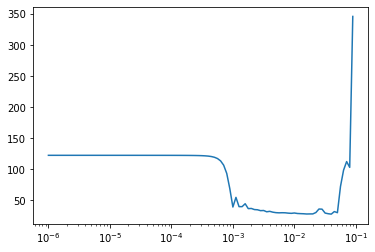

In [40]:
modelLrTune = buildModelDNN()
history = fitModelLearningRateTuner(xTrain1, yTrain1, xDev1, yDev1, 100, modelLrTune)
plt.semilogx(history.history["lr"], history.history["loss"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               768       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 16)               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


3/3 [==============================] - 1s 6ms/step - loss: 377.0891 - mae: 377.0891
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 380.5323 - mae: 380.5323
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 377.0234 - mae: 377.0234
Epoch 4/100
3/3 [==============================] - 0s 6ms/step - loss: 378.2760 - mae: 378.2760
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 378.2072 - mae: 378.2072
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 378.1848 - mae: 378.1848
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 380.7350 - mae: 380.7350
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 378.6074 - mae: 378.6074
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 377.3312 - mae: 377.3312
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 377.9288 - mae: 377.9288
Epoch 11/100
3/3 [==============================] -

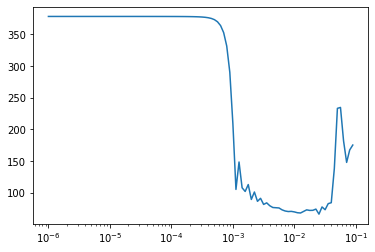

In [41]:
modelLrTune = buildModelDNN()
history2 = fitModelLearningRateTuner(xTrain2, yTrain2, xDev2, yDev2, 100, modelLrTune)
plt.semilogx(history2.history["lr"], history2.history["loss"])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 128)               768       
_________________________________________________________________
dense_145 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_146 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_147 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_148 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_149 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_150 (Dense)            (None, 16)              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


3/3 [==============================] - 1s 6ms/step - loss: 152.2891 - mae: 152.2891
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 154.2031 - mae: 154.2031
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 153.8110 - mae: 153.8110
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 155.2532 - mae: 155.2532
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 154.2762 - mae: 154.2762
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 153.3071 - mae: 153.3071
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 152.7127 - mae: 152.7127
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 154.0112 - mae: 154.0112
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 154.4596 - mae: 154.4596
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 153.9407 - mae: 153.9407
Epoch 11/100
3/3 [==============================] -

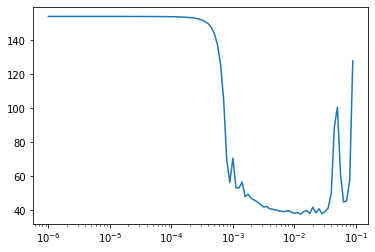

In [107]:
modelLrTune = buildModelDNN()
history3 = fitModelLearningRateTuner(xTrain3, yTrain3, xDev3, yDev3, 100, modelLrTune)
plt.semilogx(history3.history["lr"], history3.history["loss"])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_29 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_30 (Dense)             (None, 16)               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


3/3 [==============================] - 1s 8ms/step - loss: 88.3796 - mae: 88.3796
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 88.7889 - mae: 88.7889
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 87.9426 - mae: 87.9426
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 89.0434 - mae: 89.0434
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 88.8371 - mae: 88.8371
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 88.7208 - mae: 88.7208
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 88.6053 - mae: 88.6053
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 88.1868 - mae: 88.1868
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 88.3331 - mae: 88.3331
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 88.6900 - mae: 88.6900
Epoch 11/100
3/3 [==============================] - 0s 5ms/step - loss:

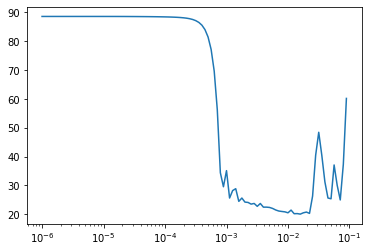

In [43]:
modelLrTune = buildModelDNN()
history4 = fitModelLearningRateTuner(xTrain4, yTrain4, xDev4, yDev4, 100, modelLrTune)
plt.semilogx(history4.history["lr"], history4.history["loss"])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_37 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_38 (Dense)             (None, 16)               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


3/3 [==============================] - 1s 6ms/step - loss: 272.8689 - mae: 272.8689
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 273.6821 - mae: 273.6821
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 271.8731 - mae: 271.8731
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 274.5204 - mae: 274.5204
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 272.8761 - mae: 272.8761
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 274.1023 - mae: 274.1023
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 271.9979 - mae: 271.9979
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 273.0407 - mae: 273.0407
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 272.5017 - mae: 272.5017
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 274.3380 - mae: 274.3380
Epoch 11/100
3/3 [==============================] -

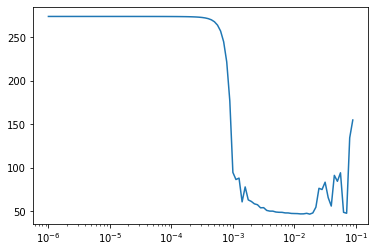

In [44]:
modelLrTune = buildModelDNN()
history5 = fitModelLearningRateTuner(xTrain5, yTrain5, xDev5, yDev5, 100, modelLrTune)
plt.semilogx(history5.history["lr"], history5.history["loss"])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_44 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_45 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_46 (Dense)             (None, 16)               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


1/1 [==============================] - 1s 982ms/step - loss: 67.3604 - mae: 67.3604
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 67.3604 - mae: 67.3604
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 67.3604 - mae: 67.3604
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 67.3604 - mae: 67.3604
Epoch 5/100
1/1 [==============================] - 0s 7ms/step - loss: 67.3604 - mae: 67.3604
Epoch 6/100
1/1 [==============================] - 0s 8ms/step - loss: 67.3604 - mae: 67.3604
Epoch 7/100
1/1 [==============================] - 0s 7ms/step - loss: 67.3604 - mae: 67.3604
Epoch 8/100
1/1 [==============================] - 0s 7ms/step - loss: 67.3604 - mae: 67.3604
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 67.3604 - mae: 67.3604
Epoch 10/100
1/1 [==============================] - 0s 7ms/step - loss: 67.3604 - mae: 67.3604
Epoch 11/100
1/1 [==============================] - 0s 10ms/step - lo

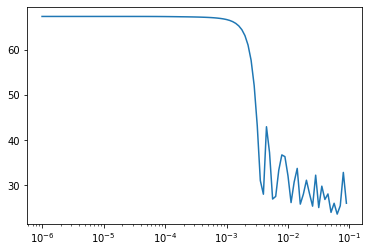

In [45]:
modelLrTune = buildModelDNN()
history6 = fitModelLearningRateTuner(xTrain6, yTrain6, xDev6, yDev6, 100, modelLrTune)
plt.semilogx(history6.history["lr"], history6.history["loss"])

Fit Model with tuned Learning Rate

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 128)               768       
_________________________________________________________________
dense_161 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_162 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_163 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_164 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_165 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_166 (Dense)            (None, 16)              

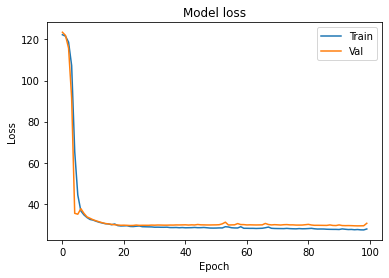

In [109]:
model1 = buildModelDNN()
model1 = compileModelAdamMseAcc(model1)
hist1 = fitModel(xTrain1, yTrain1, xDev1, yDev1, 100, model1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_57 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_58 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_59 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_60 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_61 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_62 (Dense)             (None, 16)               

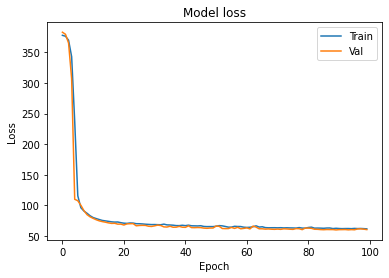

In [47]:
model2 = buildModelDNN()
model2 = compileModelAdamMseAcc(model2)
hist2 = fitModel(xTrain2, yTrain2, xDev2, yDev2, 100, model2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_65 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_66 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_67 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_68 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_69 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_70 (Dense)             (None, 16)               

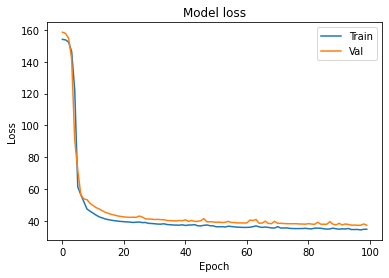

In [48]:
model3 = buildModelDNN()
model3 = compileModelAdamMseAcc(model3)
hist3 = fitModel(xTrain3, yTrain3, xDev3, yDev3, 100, model3)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_73 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_74 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_75 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_76 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_77 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_78 (Dense)             (None, 16)               

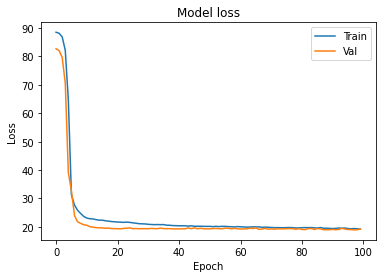

In [49]:
model4 = buildModelDNN()
model4 = compileModelAdamMseAcc(model4)
hist4 = fitModel(xTrain4, yTrain4, xDev4, yDev4, 100, model4)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_81 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_82 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_83 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_84 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_85 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_86 (Dense)             (None, 16)              

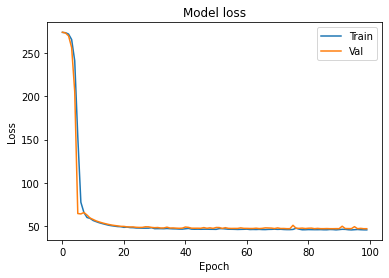

In [50]:
model5 = buildModelDNN()
model5 = compileModelAdamMseAcc(model5)
hist5 = fitModel(xTrain5, yTrain5, xDev5, yDev5, 100, model5)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_89 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_90 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_91 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_92 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_93 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_94 (Dense)             (None, 16)              

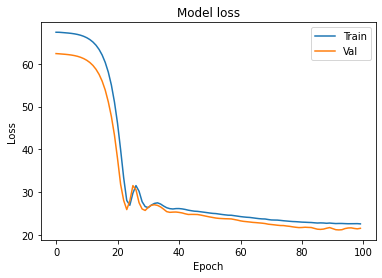

In [51]:
model6 = buildModelDNN()
model6 = compileModelAdamMseAcc(model6)
hist6 = fitModel(xTrain6, yTrain6, xDev6, yDev6, 100, model6)

In [111]:
predictionsDNN1 = model1.predict(xTest1)
print("predictions shape:", predictionsDNN1.shape)

predictions shape: (196, 1)


In [53]:
predictionsDNN2 = model2.predict(xTest2)
print("predictions shape:", predictionsDNN2.shape)

predictions shape: (196, 1)


In [54]:
predictionsDNN3 = model3.predict(xTest3)
print("predictions shape:", predictionsDNN3.shape)

predictions shape: (196, 1)


In [55]:
predictionsDNN4 = model4.predict(xTest4)
print("predictions shape:", predictionsDNN4.shape)

predictions shape: (192, 1)


In [56]:
predictionsDNN5 = model5.predict(xTest5)
print("predictions shape:", predictionsDNN5.shape)

predictions shape: (196, 1)


In [57]:
predictionsDNN6 = model6.predict(xTest6)
print("predictions shape:", predictionsDNN6.shape)

predictions shape: (37, 1)


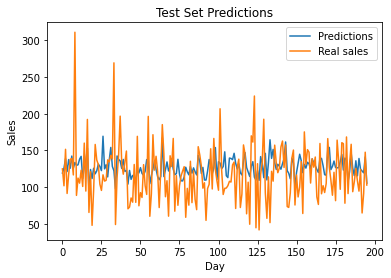

MAE:  32.6256217956543


In [112]:
plt.plot(predictionsDNN1)
plt.plot(yTest1)
plt.title('Test Set Predictions')
plt.ylabel('Sales')
plt.xlabel('Day')
plt.legend(['Predictions', 'Real sales'], loc='upper right')
plt.show()
print("MAE: ", mae(predictionsDNN1,yTest1).numpy())

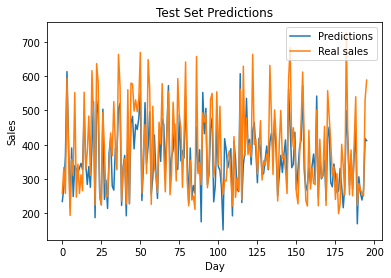

MAE:  128.63308715820312


In [59]:
plt.plot(predictionsDNN2)
plt.plot(yTest2)
plt.title('Test Set Predictions')
plt.ylabel('Sales')
plt.xlabel('Day')
plt.legend(['Predictions', 'Real sales'], loc='upper right')
plt.show()
print("MAE: ", mae(predictionsDNN2,yTest2).numpy())

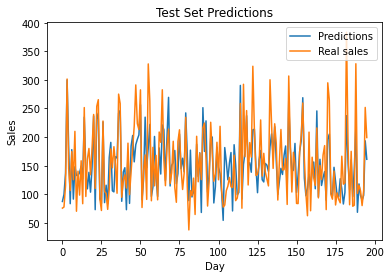

MAE:  65.13516235351562


In [60]:
plt.plot(predictionsDNN3)
plt.plot(yTest3)
plt.title('Test Set Predictions')
plt.ylabel('Sales')
plt.xlabel('Day')
plt.legend(['Predictions', 'Real sales'], loc='upper right')
plt.show()
print("MAE: ", mae(predictionsDNN3,yTest3).numpy())

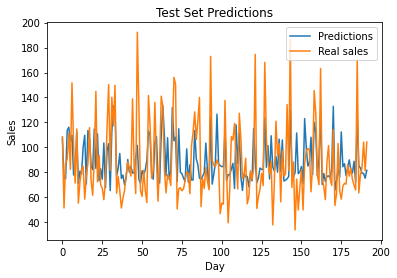

MAE:  26.813919067382812


In [61]:
plt.plot(predictionsDNN4)
plt.plot(yTest4)
plt.title('Test Set Predictions')
plt.ylabel('Sales')
plt.xlabel('Day')
plt.legend(['Predictions', 'Real sales'], loc='upper right')
plt.show()
print("MAE: ", mae(predictionsDNN4,yTest4).numpy())

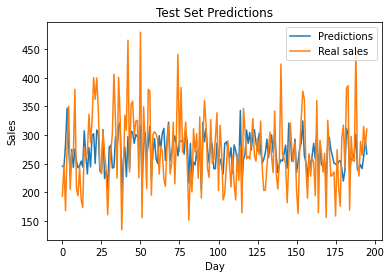

MAE:  55.50857162475586


In [62]:
plt.plot(predictionsDNN5)
plt.plot(yTest5)
plt.title('Test Set Predictions')
plt.ylabel('Sales')
plt.xlabel('Day')
plt.legend(['Predictions', 'Real sales'], loc='upper right')
plt.show()
print("MAE: ", mae(predictionsDNN5,yTest5).numpy())

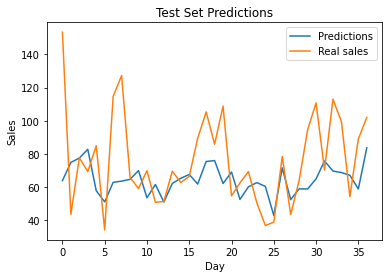

MAE:  23.777755737304688


In [63]:
plt.plot(predictionsDNN6)
plt.plot(yTest6)
plt.title('Test Set Predictions')
plt.ylabel('Sales')
plt.xlabel('Day')
plt.legend(['Predictions', 'Real sales'], loc='upper right')
plt.show()
print("MAE: ", mae(predictionsDNN6,yTest6).numpy())

##LSTM Model

To use the data in an LSTM model it needs to be prepared, i.e. drop unnecessary columns.  
Afterwards it will be reframed, so it is understood by the LSTM model.

In [64]:
scaled1 = prepareForSeriesToSupervised(sales_and_weather_combined_no_kiwo1)
reframed1 = series_to_supervised(scaled1, 1, 1)
reframed1.drop(reframed1.columns[[1,2]], axis=1, inplace=True)

In [65]:
scaled2 = prepareForSeriesToSupervised(sales_and_weather_combined_no_kiwo2)
reframed2 = series_to_supervised(scaled2, 1, 1)
reframed2.drop(reframed2.columns[[1,2]], axis=1, inplace=True)

In [66]:
scaled3 = prepareForSeriesToSupervised(sales_and_weather_combined_no_kiwo3)
reframed3 = series_to_supervised(scaled3, 1, 1)
reframed3.drop(reframed3.columns[[1,2]], axis=1, inplace=True)

In [67]:
scaled4 = prepareForSeriesToSupervised(sales_and_weather_combined_no_kiwo4)
reframed4 = series_to_supervised(scaled4, 1, 1)
reframed4.drop(reframed4.columns[[1,2]], axis=1, inplace=True)

In [68]:
scaled5 = prepareForSeriesToSupervised(sales_and_weather_combined_no_kiwo5)
reframed5 = series_to_supervised(scaled5, 1, 1)
reframed5.drop(reframed5.columns[[1,2]], axis=1, inplace=True)

In [69]:
scaled6 = prepareForSeriesToSupervised(sales_and_weather_combined_no_kiwo6)
reframed6 = series_to_supervised(scaled6, 1, 1)
reframed6.drop(reframed6.columns[[1,2]], axis=1, inplace=True)

Variables are automatically renamed when shifted for the LSTM



*   var1(t-1) is sales from yesterday
*   var1(t) is sales from today
*   var2(t) is 


var1(t) is the value that the LSTM shall predict and the other variables are the inputs for the model (i.e. X values)



In [70]:
reframed1

,var1(t-1),var1(t),var2(t),var3(t)
1,148.828353,111.885594,0.333333,0.545455
2,111.885594,168.864941,0.500000,0.545455
3,168.864941,135.500244,0.000000,0.545455
4,135.500244,135.132314,0.333333,0.545455
5,135.132314,138.549393,0.500000,0.545455
...,...,...,...,...
1566,131.607473,125.316025,0.500000,0.363636
1567,125.316025,150.801702,0.666667,0.363636
1568,150.801702,91.848541,1.000000,0.363636
1569,91.848541,190.850121,0.333333,0.363636


In [71]:
values1 = reframed1.values
xTrainLstm1, yTrainLstm1, xDevLstm1, yDevLstm1, xTestLstm1, yTestLstm1 = trainDevTestSplit(values1[:,[0,2,3]],values1[:,1], 0.25, 42)
xTrainLstm1 = xTrainLstm1.reshape((xTrainLstm1.shape[0], 1, xTrainLstm1.shape[1]))
xDevLstm1 = xDevLstm1.reshape((xDevLstm1.shape[0], 1, xDevLstm1.shape[1]))
xTestLstm1 = xTestLstm1.reshape((xTestLstm1.shape[0], 1, xTestLstm1.shape[1]))
print(xTrainLstm1.shape, yTrainLstm1.shape, xDevLstm1.shape, yDevLstm1.shape)
print(xTrainLstm1.shape[0])

(1177, 1, 3) (1177,) (197, 1, 3) (197,)
1177


In [72]:
values2 = reframed2.values
xTrainLstm2, yTrainLstm2, xDevLstm2, yDevLstm2, xTestLstm2, yTestLstm2 = trainDevTestSplit(values2[:,[0,2,3]],values2[:,1], 0.25, 42)
xTrainLstm2 = xTrainLstm2.reshape((xTrainLstm2.shape[0], 1, xTrainLstm2.shape[1]))
xDevLstm2 = xDevLstm2.reshape((xDevLstm2.shape[0], 1, xDevLstm2.shape[1]))
xTestLstm2 = xTestLstm2.reshape((xTestLstm2.shape[0], 1, xTestLstm2.shape[1]))
print(xTrainLstm2.shape, yTrainLstm2.shape, xDevLstm2.shape, yDevLstm2.shape)
print(xTrainLstm2.shape[0])

(1177, 1, 3) (1177,) (197, 1, 3) (197,)
1177


In [73]:
values3 = reframed3.values
xTrainLstm3, yTrainLstm3, xDevLstm3, yDevLstm3, xTestLstm3, yTestLstm3 = trainDevTestSplit(values3[:,[0,2,3]],values3[:,1], 0.25, 42)
xTrainLstm3 = xTrainLstm3.reshape((xTrainLstm3.shape[0], 1, xTrainLstm3.shape[1]))
xDevLstm3 = xDevLstm3.reshape((xDevLstm3.shape[0], 1, xDevLstm3.shape[1]))
xTestLstm3 = xTestLstm3.reshape((xTestLstm3.shape[0], 1, xTestLstm3.shape[1]))
print(xTrainLstm3.shape, yTrainLstm3.shape, xDevLstm3.shape, yDevLstm3.shape)
print(xTrainLstm3.shape[0])

(1177, 1, 3) (1177,) (197, 1, 3) (197,)
1177


In [74]:
values4 = reframed4.values
xTrainLstm4, yTrainLstm4, xDevLstm4, yDevLstm4, xTestLstm4, yTestLstm4 = trainDevTestSplit(values4[:,[0,2,3]],values4[:,1], 0.25, 42)
xTrainLstm4 = xTrainLstm4.reshape((xTrainLstm4.shape[0], 1, xTrainLstm4.shape[1]))
xDevLstm4 = xDevLstm4.reshape((xDevLstm4.shape[0], 1, xDevLstm4.shape[1]))
xTestLstm4 = xTestLstm4.reshape((xTestLstm4.shape[0], 1, xTestLstm4.shape[1]))
print(xTrainLstm4.shape, yTrainLstm4.shape, xDevLstm4.shape, yDevLstm4.shape)
print(xTrainLstm4.shape[0])

(1149, 1, 3) (1149,) (192, 1, 3) (192,)
1149


In [75]:
values5 = reframed5.values
xTrainLstm5, yTrainLstm5, xDevLstm5, yDevLstm5, xTestLstm5, yTestLstm5 = trainDevTestSplit(values5[:,[0,2,3]],values5[:,1], 0.25, 42)
xTrainLstm5 = xTrainLstm5.reshape((xTrainLstm5.shape[0], 1, xTrainLstm5.shape[1]))
xDevLstm5 = xDevLstm5.reshape((xDevLstm5.shape[0], 1, xDevLstm5.shape[1]))
xTestLstm5 = xTestLstm5.reshape((xTestLstm5.shape[0], 1, xTestLstm5.shape[1]))
print(xTrainLstm5.shape, yTrainLstm5.shape, xDevLstm5.shape, yDevLstm5.shape)
print(xTrainLstm5.shape[0])

(1177, 1, 3) (1177,) (197, 1, 3) (197,)
1177


In [76]:
values6 = reframed6.values
xTrainLstm6, yTrainLstm6, xDevLstm6, yDevLstm6, xTestLstm6, yTestLstm6 = trainDevTestSplit(values6[:,[0,2,3]],values6[:,1], 0.25, 42)
xTrainLstm6 = xTrainLstm6.reshape((xTrainLstm6.shape[0], 1, xTrainLstm6.shape[1]))
xDevLstm6 = xDevLstm6.reshape((xDevLstm6.shape[0], 1, xDevLstm6.shape[1]))
xTestLstm6 = xTestLstm6.reshape((xTestLstm6.shape[0], 1, xTestLstm6.shape[1]))
print(xTrainLstm6.shape, yTrainLstm6.shape, xDevLstm6.shape, yDevLstm6.shape)
print(xTrainLstm6.shape[0])

(220, 1, 3) (220,) (37, 1, 3) (37,)
220


Epoch 1/100
17/17 - 10s - loss: 121.1225 - val_loss: 114.1652
Epoch 2/100
17/17 - 0s - loss: 97.0257 - val_loss: 42.9243
Epoch 3/100
17/17 - 0s - loss: 41.6464 - val_loss: 38.4290
Epoch 4/100
17/17 - 0s - loss: 36.7379 - val_loss: 36.0143
Epoch 5/100
17/17 - 0s - loss: 34.2514 - val_loss: 31.5128
Epoch 6/100
17/17 - 0s - loss: 31.5185 - val_loss: 28.8152
Epoch 7/100
17/17 - 0s - loss: 30.5098 - val_loss: 27.9231
Epoch 8/100
17/17 - 0s - loss: 30.3748 - val_loss: 27.7650
Epoch 9/100
17/17 - 0s - loss: 30.3028 - val_loss: 27.6322
Epoch 10/100
17/17 - 0s - loss: 30.0734 - val_loss: 27.3787
Epoch 11/100
17/17 - 0s - loss: 29.9751 - val_loss: 27.2614
Epoch 12/100
17/17 - 0s - loss: 29.8632 - val_loss: 27.2179
Epoch 13/100
17/17 - 0s - loss: 29.8970 - val_loss: 27.1711
Epoch 14/100
17/17 - 0s - loss: 29.8799 - val_loss: 27.1705
Epoch 15/100
17/17 - 0s - loss: 29.7730 - val_loss: 27.0977
Epoch 16/100
17/17 - 0s - loss: 29.7683 - val_loss: 27.0787
Epoch 17/100
17/17 - 0s - loss: 29.6380 - val_

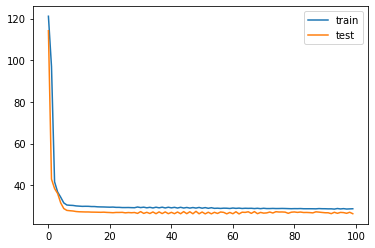

In [77]:
histLstm1, modelLstm1 = makeLstm(xTrainLstm1, yTrainLstm1, xDevLstm1, yDevLstm1)

Epoch 1/100
17/17 - 3s - loss: 374.0840 - val_loss: 358.1737
Epoch 2/100
17/17 - 0s - loss: 275.5585 - val_loss: 80.8153
Epoch 3/100
17/17 - 0s - loss: 89.0155 - val_loss: 76.4589
Epoch 4/100
17/17 - 0s - loss: 76.6810 - val_loss: 75.6791
Epoch 5/100
17/17 - 0s - loss: 74.5397 - val_loss: 74.3898
Epoch 6/100
17/17 - 0s - loss: 72.6617 - val_loss: 75.4423
Epoch 7/100
17/17 - 0s - loss: 71.4248 - val_loss: 71.8629
Epoch 8/100
17/17 - 0s - loss: 70.8671 - val_loss: 73.9488
Epoch 9/100
17/17 - 0s - loss: 70.0173 - val_loss: 70.3654
Epoch 10/100
17/17 - 0s - loss: 69.8014 - val_loss: 72.7297
Epoch 11/100
17/17 - 0s - loss: 68.7988 - val_loss: 69.0628
Epoch 12/100
17/17 - 0s - loss: 69.6491 - val_loss: 74.4976
Epoch 13/100
17/17 - 0s - loss: 68.6140 - val_loss: 68.0095
Epoch 14/100
17/17 - 0s - loss: 68.0861 - val_loss: 69.9046
Epoch 15/100
17/17 - 0s - loss: 67.2939 - val_loss: 66.7973
Epoch 16/100
17/17 - 0s - loss: 67.1281 - val_loss: 67.1698
Epoch 17/100
17/17 - 0s - loss: 67.0645 - val_

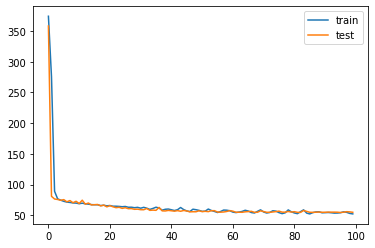

In [78]:
histLstm2, modelLstm2 = makeLstm(xTrainLstm2, yTrainLstm2, xDevLstm2, yDevLstm2)

Epoch 1/100
17/17 - 3s - loss: 147.4669 - val_loss: 131.2905
Epoch 2/100
17/17 - 0s - loss: 79.2524 - val_loss: 52.9490
Epoch 3/100
17/17 - 0s - loss: 38.5974 - val_loss: 37.0327
Epoch 4/100
17/17 - 0s - loss: 34.9864 - val_loss: 35.9850
Epoch 5/100
17/17 - 0s - loss: 33.7897 - val_loss: 35.9903
Epoch 6/100
17/17 - 0s - loss: 33.6321 - val_loss: 35.8268
Epoch 7/100
17/17 - 0s - loss: 33.4774 - val_loss: 35.5841
Epoch 8/100
17/17 - 0s - loss: 33.3601 - val_loss: 35.3678
Epoch 9/100
17/17 - 0s - loss: 33.2463 - val_loss: 35.2280
Epoch 10/100
17/17 - 0s - loss: 33.0755 - val_loss: 35.0686
Epoch 11/100
17/17 - 0s - loss: 32.9099 - val_loss: 34.9318
Epoch 12/100
17/17 - 0s - loss: 32.7627 - val_loss: 34.7422
Epoch 13/100
17/17 - 0s - loss: 32.6011 - val_loss: 34.4183
Epoch 14/100
17/17 - 0s - loss: 32.3906 - val_loss: 34.2297
Epoch 15/100
17/17 - 0s - loss: 32.1955 - val_loss: 33.9011
Epoch 16/100
17/17 - 0s - loss: 31.8627 - val_loss: 33.5010
Epoch 17/100
17/17 - 0s - loss: 31.9105 - val_l

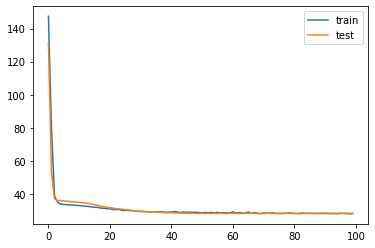

In [79]:
histLstm3, modelLstm3 = makeLstm(xTrainLstm3, yTrainLstm3, xDevLstm3, yDevLstm3)

Epoch 1/100
16/16 - 3s - loss: 83.3531 - val_loss: 78.1707
Epoch 2/100
16/16 - 0s - loss: 49.6670 - val_loss: 34.2560
Epoch 3/100
16/16 - 0s - loss: 30.5010 - val_loss: 29.0942
Epoch 4/100
16/16 - 0s - loss: 27.6546 - val_loss: 27.5931
Epoch 5/100
16/16 - 0s - loss: 24.9800 - val_loss: 24.1576
Epoch 6/100
16/16 - 0s - loss: 23.0294 - val_loss: 22.5688
Epoch 7/100
16/16 - 0s - loss: 22.0949 - val_loss: 22.2241
Epoch 8/100
16/16 - 0s - loss: 21.6140 - val_loss: 21.9817
Epoch 9/100
16/16 - 0s - loss: 21.3556 - val_loss: 21.6707
Epoch 10/100
16/16 - 0s - loss: 21.2761 - val_loss: 21.7524
Epoch 11/100
16/16 - 0s - loss: 21.2244 - val_loss: 21.8875
Epoch 12/100
16/16 - 0s - loss: 21.0179 - val_loss: 21.4357
Epoch 13/100
16/16 - 0s - loss: 20.9695 - val_loss: 21.4858
Epoch 14/100
16/16 - 0s - loss: 20.9439 - val_loss: 22.0481
Epoch 15/100
16/16 - 0s - loss: 20.7402 - val_loss: 20.9911
Epoch 16/100
16/16 - 0s - loss: 20.9233 - val_loss: 22.2995
Epoch 17/100
16/16 - 0s - loss: 20.6099 - val_los

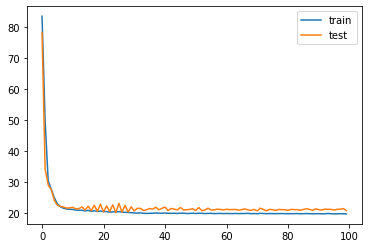

In [80]:
histLstm4, modelLstm4 = makeLstm(xTrainLstm4, yTrainLstm4, xDevLstm4, yDevLstm4)

Epoch 1/100
17/17 - 3s - loss: 272.1642 - val_loss: 269.2514
Epoch 2/100
17/17 - 0s - loss: 254.7017 - val_loss: 209.7287
Epoch 3/100
17/17 - 0s - loss: 106.2387 - val_loss: 63.3820
Epoch 4/100
17/17 - 0s - loss: 55.9353 - val_loss: 59.7132
Epoch 5/100
17/17 - 0s - loss: 51.6040 - val_loss: 58.1905
Epoch 6/100
17/17 - 0s - loss: 49.3460 - val_loss: 55.1096
Epoch 7/100
17/17 - 0s - loss: 47.5948 - val_loss: 54.3344
Epoch 8/100
17/17 - 0s - loss: 46.9884 - val_loss: 53.7504
Epoch 9/100
17/17 - 0s - loss: 46.0364 - val_loss: 51.6703
Epoch 10/100
17/17 - 0s - loss: 46.3595 - val_loss: 51.3653
Epoch 11/100
17/17 - 0s - loss: 46.1598 - val_loss: 51.2140
Epoch 12/100
17/17 - 0s - loss: 45.2227 - val_loss: 49.9450
Epoch 13/100
17/17 - 0s - loss: 45.3513 - val_loss: 49.7528
Epoch 14/100
17/17 - 0s - loss: 45.1927 - val_loss: 49.2549
Epoch 15/100
17/17 - 0s - loss: 44.9227 - val_loss: 49.0402
Epoch 16/100
17/17 - 0s - loss: 44.7567 - val_loss: 48.1990
Epoch 17/100
17/17 - 0s - loss: 44.8133 - va

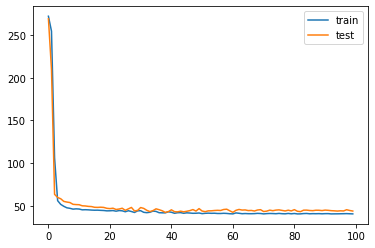

In [81]:
histLstm5, modelLstm5 = makeLstm(xTrainLstm5, yTrainLstm5, xDevLstm5, yDevLstm5)

Epoch 1/100
4/4 - 3s - loss: 68.5828 - val_loss: 63.2401
Epoch 2/100
4/4 - 0s - loss: 67.8575 - val_loss: 62.1350
Epoch 3/100
4/4 - 0s - loss: 66.6168 - val_loss: 60.1709
Epoch 4/100
4/4 - 0s - loss: 64.3725 - val_loss: 56.4767
Epoch 5/100
4/4 - 0s - loss: 60.1491 - val_loss: 49.5555
Epoch 6/100
4/4 - 0s - loss: 52.3306 - val_loss: 36.7718
Epoch 7/100
4/4 - 0s - loss: 38.8109 - val_loss: 22.1842
Epoch 8/100
4/4 - 0s - loss: 26.4797 - val_loss: 29.4640
Epoch 9/100
4/4 - 0s - loss: 31.2993 - val_loss: 31.3082
Epoch 10/100
4/4 - 0s - loss: 29.0407 - val_loss: 22.3149
Epoch 11/100
4/4 - 0s - loss: 24.8553 - val_loss: 19.8439
Epoch 12/100
4/4 - 0s - loss: 25.0207 - val_loss: 20.1646
Epoch 13/100
4/4 - 0s - loss: 24.8185 - val_loss: 19.3267
Epoch 14/100
4/4 - 0s - loss: 23.8175 - val_loss: 21.5570
Epoch 15/100
4/4 - 0s - loss: 24.1376 - val_loss: 22.5135
Epoch 16/100
4/4 - 0s - loss: 23.8033 - val_loss: 20.4295
Epoch 17/100
4/4 - 0s - loss: 22.8518 - val_loss: 19.3682
Epoch 18/100
4/4 - 0s -

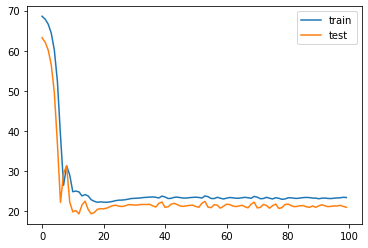

In [82]:
histLstm6, modelLstm6 = makeLstm(xTrainLstm6, yTrainLstm6, xDevLstm6, yDevLstm6)

Predict the test set

In [83]:
predictionsLstm1 = modelLstm1.predict(xTestLstm1)
print("predictions shape:", predictionsLstm1.shape)

predictions shape: (196, 1)


In [84]:
predictionsLstm2 = modelLstm2.predict(xTestLstm2)
print("predictions shape:", predictionsLstm2.shape)

predictions shape: (196, 1)


In [85]:
predictionsLstm3 = modelLstm3.predict(xTestLstm3)
print("predictions shape:", predictionsLstm3.shape)

predictions shape: (196, 1)


In [86]:
predictionsLstm4 = modelLstm4.predict(xTestLstm4)
print("predictions shape:", predictionsLstm4.shape)

predictions shape: (191, 1)


In [87]:
predictionsLstm5 = modelLstm5.predict(xTestLstm5)
print("predictions shape:", predictionsLstm5.shape)

predictions shape: (196, 1)


In [88]:
predictionsLstm6 = modelLstm6.predict(xTestLstm6)
print("predictions shape:", predictionsLstm6.shape)

predictions shape: (37, 1)


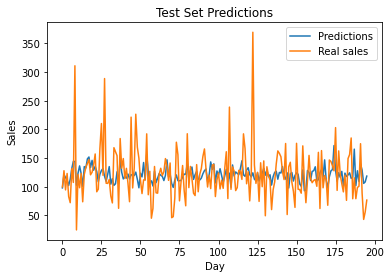

MAE:  33.265621185302734


In [89]:
plt.plot(predictionsLstm1)
plt.plot(yTestLstm1)
plt.title('Test Set Predictions')
plt.ylabel('Sales')
plt.xlabel('Day')
plt.legend(['Predictions', 'Real sales'], loc='upper right')
plt.show()
print("MAE: ", mae(predictionsLstm1,yTestLstm1).numpy())

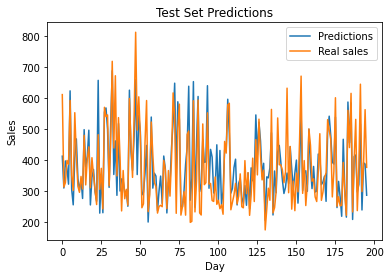

MAE:  130.9195098876953


In [90]:
plt.plot(predictionsLstm2)
plt.plot(yTestLstm2)
plt.title('Test Set Predictions')
plt.ylabel('Sales')
plt.xlabel('Day')
plt.legend(['Predictions', 'Real sales'], loc='upper right')
plt.show()
print("MAE: ", mae(predictionsLstm2,yTestLstm2).numpy())

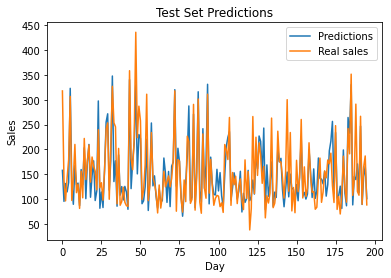

MAE:  70.37812805175781


In [91]:
plt.plot(predictionsLstm3)
plt.plot(yTestLstm3)
plt.title('Test Set Predictions')
plt.ylabel('Sales')
plt.xlabel('Day')
plt.legend(['Predictions', 'Real sales'], loc='upper right')
plt.show()
print("MAE: ", mae(predictionsLstm3,yTestLstm3).numpy())

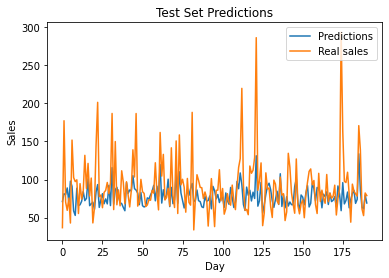

MAE:  28.06049346923828


In [92]:
plt.plot(predictionsLstm4)
plt.plot(yTestLstm4)
plt.title('Test Set Predictions')
plt.ylabel('Sales')
plt.xlabel('Day')
plt.legend(['Predictions', 'Real sales'], loc='upper right')
plt.show()
print("MAE: ", mae(predictionsLstm4,yTestLstm4).numpy())

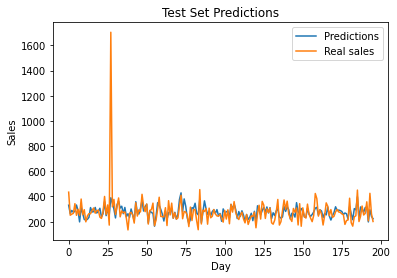

MAE:  69.04885864257812


In [93]:
plt.plot(predictionsLstm5)
plt.plot(yTestLstm5)
plt.title('Test Set Predictions')
plt.ylabel('Sales')
plt.xlabel('Day')
plt.legend(['Predictions', 'Real sales'], loc='upper right')
plt.show()
print("MAE: ", mae(predictionsLstm5,yTestLstm5).numpy())

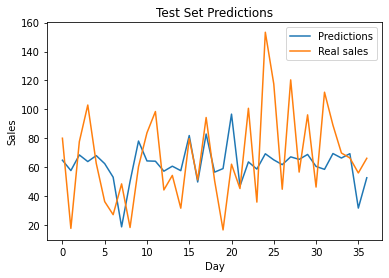

MAE:  27.167755126953125


In [94]:
plt.plot(predictionsLstm6)
plt.plot(yTestLstm6)
plt.title('Test Set Predictions')
plt.ylabel('Sales')
plt.xlabel('Day')
plt.legend(['Predictions', 'Real sales'], loc='upper right')
plt.show()
print("MAE: ", mae(predictionsLstm6,yTestLstm6).numpy())

## Fourier Analysis

The idea of Fourier coefficients is, that functions can be written as a sum of
sinus and cosinus functions. That is possible for continuous functions f on a bounded interval $[a,b]$ as we need (see for example: https://de.wikipedia.org/wiki/Fourierreihe Konvergenzaussagen zur Fourierreihe)
$ f \in L^2[a,b]$, which means 
$$\int_a^b |f(x)|^2\, dx<\infty $$,
which is for continuous functions trivially fulfilled. The discrete case is in some way anlogue as a sum can just be identified as an integral. Hence we want to approximate the fourier transform of a function $f$
$$ \frac{a_0}{2}+\sum_{k=1}^{\infty}  a_k\cos(kt)+b_k\sin(kt)$$
For data compression we just take the summands, which have the biggest $a_k$, $b_k$. They do not have to be the first $n\in \mathbb{N}$. It could be also for example $k=1,10,100$.  

The idea is, to use this for extrapolation and not for data compression. The formulars used, are for example given in the Optimization and Data Science course from Christian-Albrechts-Universität zu Kiel summer semester $2021$ lecture $3$ and $4$.

First we want to get the optimal number of fourier coefficients.  
It is justed tryed, which number of fourier coefficents is good. There is not a strategy behind.  
Finding of the optimal number could be done faster by different programming.  
Also only the first 200 biggest fourier coefficients are tested.  

In [96]:
print('optimal number')
print(optimal_number_fouriercoefficients(yTrain1,yDev1))
print(optimal_number_fouriercoefficients(yTrain2,yDev2))
print(optimal_number_fouriercoefficients(yTrain3,yDev3))
print(optimal_number_fouriercoefficients(yTrain4,yDev4))
print(optimal_number_fouriercoefficients(yTrain5,yDev5))
print(optimal_number_fouriercoefficients(yTrain6,yDev6))



optimal number
199
199
199
199
199
199


Fourier
train
[0.75  0.875 0.75  ... 0.375 0.125 0.875]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


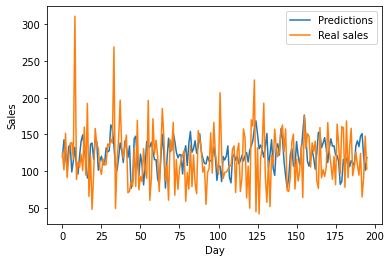

mae for fourier analysis
33.65871047973633
Moving average


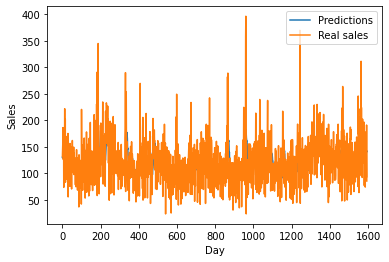

mae for moving average
34.41184997558594


In [97]:
print('Fourier')
helpz = np.zeros((len(yTest1),1))
print('train')
print(xTrain1[:,0])
helpz = FourierAnalysis(yTrain1,200,helpz)
Plotting(helpz,yTest1)
print('mae for fourier analysis')
print(mae(helpz,yTest1).numpy())  
print('Moving average')
Plotting(MovingAverage(sales_and_weather_group1),sales_and_weather_group1.iloc[10:,2])
print('mae for moving average')
print(mae(MovingAverage(sales_and_weather_combined_no_kiwo1),sales_and_weather_combined_no_kiwo1.iloc[10:,2]).numpy())

Fourier
train
[0.75  0.875 0.75  ... 0.375 0.125 0.875]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


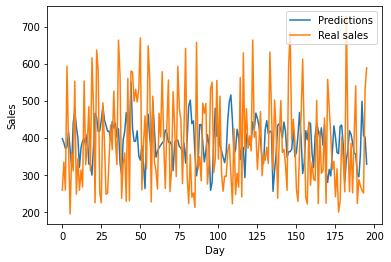

mae for fourier analysis
114.1567153930664
Moving average


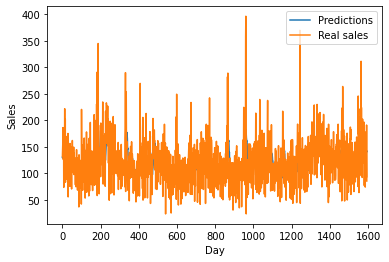

mae for moving average
127.6275405883789


In [106]:
print('Fourier')
helpz = np.zeros((len(yTest2),1))
print('train')
print(xTrain2[:,0])
helpz = FourierAnalysis(yTrain2,200,helpz)
Plotting(helpz,yTest2)
print('mae for fourier analysis')
print(mae(helpz,yTest2).numpy())  
print('Moving average')
Plotting(MovingAverage(sales_and_weather_group1),sales_and_weather_group1.iloc[10:,2])
print('mae for moving average')
print(mae(MovingAverage(sales_and_weather_combined_no_kiwo2),sales_and_weather_combined_no_kiwo2.iloc[10:,2]).numpy())

Fourier
train
[0.75  0.875 0.75  ... 0.375 0.125 0.875]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


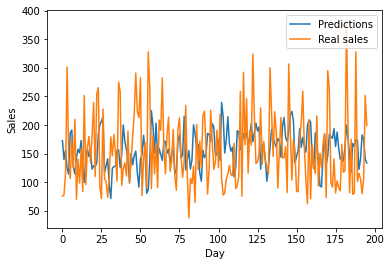

mae for fourier analysis
58.58291244506836
Moving average


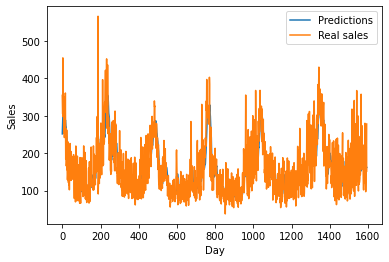

mae for moving average
70.34101104736328


In [99]:
print('Fourier')
helpz = np.zeros((len(yTest3),1))
print('train')
print(xTrain3[:,0])
helpz = FourierAnalysis(yTrain3,200,helpz)
Plotting(helpz,yTest3)
print('mae for fourier analysis')
print(mae(helpz,yTest3).numpy())  
print('Moving average')
Plotting(MovingAverage(sales_and_weather_group3),sales_and_weather_group3.iloc[10:,2])
print('mae for moving average')
print(mae(MovingAverage(sales_and_weather_combined_no_kiwo3),sales_and_weather_combined_no_kiwo3.iloc[10:,2]).numpy())

Fourier
train
[0.875 0.875 0.875 ... 1.    0.625 1.   ]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


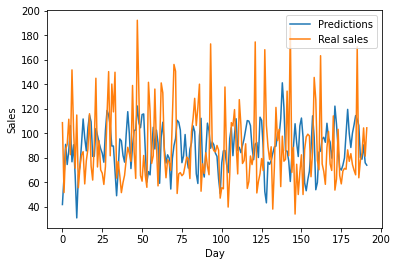

mae for fourier analysis
27.857702255249023
Moving average


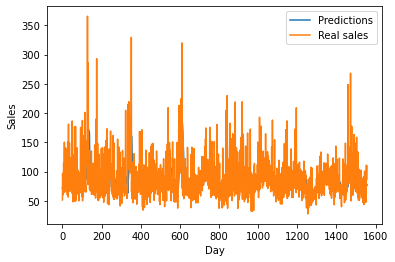

mae for moving average
26.72641372680664


In [100]:
print('Fourier')
helpz = np.zeros((len(yTest4),1))
print('train')
print(xTrain4[:,0])
helpz = FourierAnalysis(yTrain4,200,helpz)
Plotting(helpz,yTest4)
print('mae for fourier analysis')
print(mae(helpz,yTest4).numpy())  
print('Moving average')
Plotting(MovingAverage(sales_and_weather_group4),sales_and_weather_group4.iloc[10:,2])
print('mae for moving average')
print(mae(MovingAverage(sales_and_weather_combined_no_kiwo4),sales_and_weather_combined_no_kiwo4.iloc[10:,2]).numpy())

Fourier
train
[0.75  0.875 0.75  ... 0.375 0.125 0.875]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


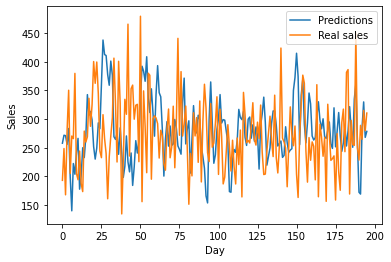

mae for fourier analysis
66.55809020996094
Moving average


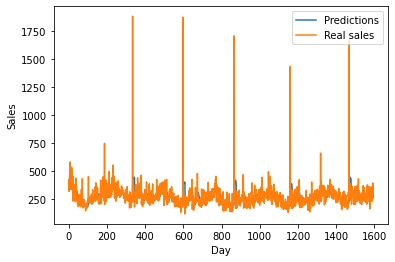

mae for moving average
66.35481262207031


In [101]:
print('Fourier')
helpz = np.zeros((len(yTest5),1))
print('train')
print(xTrain5[:,0])
helpz = FourierAnalysis(yTrain5,200,helpz)
Plotting(helpz,yTest5)
print('mae for fourier analysis')
print(mae(helpz,yTest5).numpy())  
print('Moving average')
Plotting(MovingAverage(sales_and_weather_group5),sales_and_weather_group5.iloc[10:,2])
print('mae for moving average')
print(mae(MovingAverage(sales_and_weather_combined_no_kiwo5),sales_and_weather_combined_no_kiwo5.iloc[10:,2]).numpy())

Fourier
train
[0.75  1.    0.625 0.25  0.875 0.75  1.    0.875 0.875 0.875 0.875 0.375
 1.    0.875 1.    0.875 0.875 0.5   0.875 0.875 0.875 0.625 0.875 0.875
 0.875 0.875 0.375 0.875 0.875 0.875 0.625 0.75  0.25  1.    0.875 0.875
 0.875 1.    0.875 0.375 0.625 0.25  1.    0.125 0.875 0.875 0.875 0.875
 0.875 0.875 0.    0.875 1.    0.875 1.    1.    0.375 0.625 1.    1.
 0.75  0.5   0.375 0.875 0.875 0.875 0.    1.    0.875 0.875 0.875 0.875
 0.875 1.    0.875 0.875 0.875 1.    0.625 0.5   1.    0.625 0.375 0.
 0.875 0.875 0.875 0.5   0.75  0.625 0.875 0.875 0.875 0.75  1.    0.875
 0.625 0.875 0.625 0.75  0.625 1.    0.875 0.875 0.875 0.875 0.625 0.875
 0.875 1.    1.    0.5   0.875 0.875 0.875 0.375 0.875 0.875 0.875 1.
 0.5   0.875 0.75  0.    0.    0.75  0.875 0.875 1.    0.875 0.25  0.25
 0.875 0.875 0.875 0.875 0.75  0.875 0.875 0.25  1.    0.875 1.    0.875
 0.875 1.    0.375 1.    0.    0.75  0.625 1.    0.625 0.875 1.    1.
 0.75  0.875 1.    0.875 1.    0.875 0.875 0.875 0

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


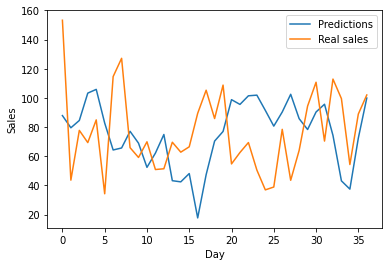

mae for fourier analysis
28.112796783447266
Moving average


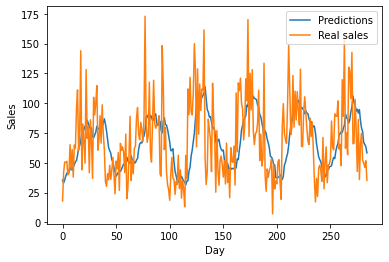

mae for moving average
30.608381271362305


In [102]:
print('Fourier')
helpz = np.zeros((len(yTest6),1))
print('train')
print(xTrain6[:,0])
helpz = FourierAnalysis(yTrain6,200,helpz)
Plotting(helpz,yTest6)
print('mae for fourier analysis')
print(mae(helpz,yTest6).numpy())  
print('Moving average')
Plotting(MovingAverage(sales_and_weather_group6),sales_and_weather_group6.iloc[10:,2])
print('mae for moving average')
print(mae(MovingAverage(sales_and_weather_combined_no_kiwo6),sales_and_weather_combined_no_kiwo6.iloc[10:,2]).numpy())

# Conclusion

The average MAE over all 6 sales groups was best with the Fourier approach with 54.82 and worst with the LSTM model with 59.89 (DNN: 55.29 / Moving Average: 59.34). The approaches are all close together and while Fourier and DNN are on the lower edge and LSTM and Moving Average on the higher edge of the error it shows that the result is not influenced by the complexity of the model, but rather by how good the model can fit the data. Probably more in depth tuning of the LSTM could have led to better results with this model. Also even without any knowledge about Neural Networks a simple approach with a moving average can already help a lot in predicting the sales.

The weather data had only very little influence on the loss and accuracy in the prediction, hence is has been removed from the dataset for training. This is maybe also a reason, why the moving average is a good indicator, as it also does not look on the weather data. On the other hand we added the day of the week, as we considered this information to be important, because in Germany for example on sundays the supermarkets are closed but bakeries are open.